# Import libraries

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
import lightgbm
import catboost
import optuna
import tqdm as notebook_tqdm

# Load data

In [40]:
train_data = pd.read_csv('data/hackathon_income_train.csv', delimiter=';', decimal=',', parse_dates=['dt'], dayfirst=False)
train_data.head()

/var/folders/_2/3r2pyzk16rdbwgbf6s6rlngr0000gn/T/ipykernel_28004/4046706259.py:1: DtypeWarning: Columns (66) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('data/hackathon_income_train.csv', delimiter=';', decimal=',', parse_dates=['dt'], dayfirst=False)


,id,dt,target,turn_cur_cr_avg_act_v2,salary_6to12m_avg,hdb_bki_total_max_limit,dp_ils_paymentssum_avg_12m,hdb_bki_total_cc_max_limit,incomeValue,gender,...,dp_ils_uniq_companies_1y,avg_6m_travel,avg_6m_government_services,hdb_bki_active_cc_max_overdue,total_rur_amt_cm_avg_period_days_ago_v2,label_Above_1M_share_r1,transaction_category_supermarket_sum_cnt_d15,max_balance_rur_amt_1m_af,w,first_salary_income
0,2,2024-04-30,109324.476325,1465144.960,NaN,52800.0,365346.244634,23213.0,97366.0,Женский,...,1.0,0.0,57.0,0.0,297.0,0.027027,9.0,NaN,0.301217,NaN
1,4,2024-02-29,25558.028662,303593.660,NaN,260200.0,NaN,10000.0,32580.0,Женский,...,NaN,0.0,707.0,67.0,30245.0,NaN,2.0,NaN,0.695800,NaN
2,5,2024-02-29,40666.753098,490754.010,NaN,2000000.0,NaN,90000.0,96866.0,Женский,...,NaN,422.0,0.0,0.0,210322.0,0.000000,20.0,NaN,0.515970,NaN
3,6,2024-04-30,43856.672058,219875.120,NaN,75000.0,NaN,75000.0,43860.0,Мужской,...,NaN,0.0,0.0,0.0,7187.0,0.000000,7.0,NaN,0.478003,NaN
4,7,2024-04-30,130420.851992,1750241.845,NaN,1000000.0,NaN,240000.0,83815.0,Женский,...,NaN,0.0,84.0,0.0,690038.0,0.000000,9.0,NaN,0.552314,NaN


In [41]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76786 entries, 0 to 76785
Columns: 224 entries, id to first_salary_income
dtypes: datetime64[ns](1), float64(182), int64(1), object(40)
memory usage: 131.2+ MB


In [42]:
test_data = pd.read_csv('data/hackathon_income_test.csv', delimiter=';', decimal=',', parse_dates=['dt'], dayfirst=False)
test_data.head()

/var/folders/_2/3r2pyzk16rdbwgbf6s6rlngr0000gn/T/ipykernel_28004/1370680547.py:1: DtypeWarning: Columns (65) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv('data/hackathon_income_test.csv', delimiter=';', decimal=',', parse_dates=['dt'], dayfirst=False)


,id,dt,turn_cur_cr_avg_act_v2,salary_6to12m_avg,hdb_bki_total_max_limit,dp_ils_paymentssum_avg_12m,hdb_bki_total_cc_max_limit,incomeValue,gender,avg_cur_cr_turn,...,total_sum,dp_ils_uniq_companies_1y,avg_6m_travel,avg_6m_government_services,hdb_bki_active_cc_max_overdue,total_rur_amt_cm_avg_period_days_ago_v2,label_Above_1M_share_r1,transaction_category_supermarket_sum_cnt_d15,max_balance_rur_amt_1m_af,first_salary_income
0,0,2024-08-31,805319.38,NaN,61137.47,NaN,60000.0,159999.0,Женский,69740.0,...,NaN,NaN,0.0,0.0,NaN,80228.0,0.0,1.0,NaN,NaN
1,1,2024-10-31,306240.00,NaN,949500.0,NaN,230000.0,108834.0,Мужской,63513.0,...,0.00,NaN,0.0,0.0,0.0,24888.0,0.0,NaN,NaN,NaN
2,3,2024-09-30,164908.73,NaN,178000.0,NaN,178000.0,59203.0,Женский,132.0,...,38630.63,NaN,0.0,0.0,2363.9,223.0,NaN,NaN,NaN,NaN
3,9,2024-10-31,2374846.42,NaN,25500.0,126247.448359,4999.0,180906.0,Женский,290339.0,...,NaN,3.0,800.0,0.0,NaN,25734.0,0.0,7.0,0.0,NaN
4,11,2024-11-30,735902.71,47828.145621,60000.0,NaN,60000.0,24922.0,Мужской,76924.0,...,0.00,NaN,0.0,0.0,0.0,1214.0,0.0,15.0,NaN,NaN


In [18]:
test_data.columns[65]

'dp_address_unique_regions'

In [20]:
test_data.iloc[:,65].unique()

array([nan, '22', '25', '39', '61', '47', '77,50', '78', '74', '52', '71',
       '66', '59,66', '24', '16', '91,77,23', '23', '58', '67', '55',
       '35', '64', '77', '18', '50', '26', '50,12', '59', '86', '02',
       '30', '36', '38', '29', '72', '54', '73', '40', '61,23', '32',
       '42', '37', '50,25', '35,50', '77,21', '34', '05', '77,14', '76',
       '10,59', '66,72', '24,78', '40,77', '14', '11', '27', '33,52',
       '70', '46', '38,16,63', '21', '69', '74,55', '19', '63', '61,47',
       '75', '43,66', '89', '03', '62', '57,50', '12', '78,86', '56',
       '77,68', '47,78', '56,66', '68', '16,02', '47,72', '86,72', '51',
       '33', '23,66', '42,54', '10', '50,23', '60', '77,78', '02,16',
       '43,78', '50,77,16', '31', '43', '78,47', '45', '02,63', '50,77',
       '48', '16,12', '43,77', '94,61', '77,63', '57', '77,67', '22,42',
       '77,62', '86,77', '34,78', '13', '65', '71,54', '77,02,50',
       '26,42', '15,78', '21,77', '42,50', '50,32', '50,38', '23,31',
   

In [11]:
features = pd.read_csv('data/features_description.csv', delimiter=';', encoding='windows-1251')
features.head()

,признак,описание
0,dt,Дата актуальности признаков
1,target,таргет
2,turn_cur_cr_avg_act_v2,Средний текущий кредитовый оборот по текущим с...
3,salary_6to12m_avg,Усреднённая ЗП клиента за окно в минимум 6 мес...
4,hdb_bki_total_max_limit,БКИ: Максимальный кредитный лимит по любому пр...


In [12]:
features.shape

(224, 2)

# EDA

# Проверка уникальности клиентов/записей

In [47]:
set(train_data.id) & set(test_data.id)

set()

Пересекающихся клиентов нет

In [50]:
print(f'Всего записей: {train_data.shape[0]}\nКол-во уникальных id: {train_data.id.nunique()}')

Всего записей: 76786
Кол-во уникальных id: 76786


In [22]:
features.loc[features['признак'] == 'dp_address_unique_regions']

,признак,описание
65,dp_address_unique_regions,данные цифрового профиля


In [23]:
train_data.describe()

,id,target,turn_cur_cr_avg_act_v2,salary_6to12m_avg,dp_ils_paymentssum_avg_12m,incomeValue,avg_cur_cr_turn,turn_cur_cr_avg_v2,turn_cur_cr_max_v2,age,...,total_sum,dp_ils_uniq_companies_1y,avg_6m_travel,avg_6m_government_services,total_rur_amt_cm_avg_period_days_ago_v2,label_Above_1M_share_r1,transaction_category_supermarket_sum_cnt_d15,max_balance_rur_amt_1m_af,w,first_salary_income
count,76786.000000,7.678600e+04,5.907800e+04,1.487500e+04,1.650300e+04,63817.000000,6.021400e+04,5.943200e+04,5.943200e+04,76786.000000,...,4.800700e+04,16589.000000,55130.000000,55130.000000,7.316600e+04,34010.000000,34934.000000,1.113300e+04,76786.000000,8.668000e+03
mean,75070.250540,9.264824e+04,1.170105e+06,1.174897e+05,2.162228e+05,81682.344469,1.866825e+05,1.601873e+05,3.200456e+05,37.772354,...,4.384647e+04,1.454819,912.809305,275.162561,9.641689e+04,0.008593,12.909286,1.360850e+05,0.569014,2.052949e+05
std,43362.283111,1.124090e+05,2.205263e+06,1.603782e+05,2.538178e+05,51306.983613,4.615432e+05,3.500297e+05,8.496348e+05,11.338095,...,8.098149e+05,0.886676,6249.867314,2107.505699,5.695752e+05,0.022440,11.214355,2.517752e+06,0.551835,1.515545e+05
min,2.000000,2.000000e+04,1.000000e-02,2.000374e+04,2.648938e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,14.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,-2.000000e+00,0.000021,-7.982345e+04
25%,37519.250000,3.970997e+04,2.039768e+05,4.872909e+04,9.280878e+04,46223.000000,1.580175e+04,1.994257e+04,3.534457e+04,29.000000,...,0.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,5.000000,2.000000e+00,0.235950,1.264576e+05
50%,74975.500000,6.275413e+04,5.940204e+05,7.309241e+04,1.497120e+05,67474.000000,7.436150e+04,6.769552e+04,9.000000e+04,37.000000,...,0.000000e+00,1.000000,0.000000,0.000000,2.000000e+03,0.000000,10.000000,5.250000e+02,0.449424,1.769727e+05
75%,112835.500000,1.002017e+05,1.268697e+06,1.222903e+05,2.422720e+05,101340.000000,1.754025e+05,1.612852e+05,2.602045e+05,45.000000,...,3.511880e+03,2.000000,0.000000,0.000000,1.978700e+04,0.007463,18.000000,4.058000e+03,0.680337,2.378084e+05
max,149999.000000,1.500000e+06,6.545863e+07,3.419392e+06,4.754632e+06,542084.000000,1.702021e+07,1.328000e+07,2.961870e+07,86.000000,...,1.285996e+08,15.000000,287382.000000,310266.000000,4.263312e+07,0.428571,133.000000,2.374923e+08,2.570703,1.650302e+06


# Feature engineering

## Filling NA

In [51]:
train_data.isna().sum().sum()

np.int64(7165273)

In [52]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

In [57]:
cleaned_train = train_data.copy()
num_cols = cleaned_train.select_dtypes(include=['int', 'float'])
cleaned_train[num_cols] = imp.fit_transform(cleaned_train[num_cols])
cleaned_train.isna().sum().sum()

ValueError: Boolean array expected for the condition, not int64

# Model train and test

In [58]:
# metric define
def weighted_mean_absolute_error(y_true, y_pred, weights):
    return (weights * np.abs(y_true - y_pred)).mean()


In [79]:
X = train_data.drop(columns=['id', 'dt', 'target', 'w'])
object_col = X.select_dtypes(include=['object']).columns
X[object_col] = X[object_col].astype('category')
w = train_data['w']
y = train_data['target']

In [85]:
np.log2(X.shape[1])

np.float64(7.78135971352466)

## LightGBM

In [ ]:
def objective_lgbm(trial):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 150, 2000),
        'max_depth': trial.suggest_int("max_depth", 7, 9),
        'num_leaves': trial.suggest_int('num_leaves', 15, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float("subsample", 0.5, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'boosting_type': 'gbdt',
        'n_jobs': -1,
        'random_state': 23
    }
    
    model = lightgbm.LGBMRegressor(**params)

    splitter = KFold(n_splits=5, shuffle=True, random_state=23)

    y_log = np.log1p(y)

    wmean_mae = []

    for _, (train_index, valid_index) in enumerate(splitter.split(X, y)):

        X_train , y_train = X.iloc[train_index], y_log.iloc[train_index]
        X_valid, y_valid, w_valid = X.iloc[valid_index], y_log.iloc[valid_index], w.iloc[valid_index]

        model.fit(X_train, y_train,
                eval_metric='mae', eval_set=[(X_valid, y_valid)],
                    callbacks=[lightgbm.early_stopping(50), lightgbm.log_evaluation(period=0)])
        
        y_pred = model.predict(X_valid)
        wmean_mae.append(weighted_mean_absolute_error(np.expm1(y_valid), np.expm1(y_pred), w_valid))
    
    return np.mean(wmean_mae)

In [83]:
study = optuna.create_study(study_name="lgbm_opt", direction="minimize")
study.optimize(objective_lgbm, n_trials=50, show_progress_bar=True)

[I 2025-11-28 22:00:01,336] A new study created in memory with name: lgbm_opt
  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the train set: 61428, number of used features: 220
[LightGBM] [Info] Start training from score 11.110472
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[92]	valid_0's l1: 0.379898	valid_0's l2: 0.256484
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large numb

Best trial: 0. Best value: 44228.3:   2%|▏         | 1/50 [00:13<10:58, 13.45s/it]

Early stopping, best iteration is:
[98]	valid_0's l1: 0.376425	valid_0's l2: 0.25309
[I 2025-11-28 22:00:14,783] Trial 0 finished with value: 44228.343583141286 and parameters: {'n_estimators': 273, 'max_depth': 10, 'num_leaves': 17, 'learning_rate': 0.12202649097372668, 'subsample': 0.5371106007871578, 'colsample_bytree': 0.6366150374329853, 'reg_alpha': 0.0381503703464155, 'reg_lambda': 0.04711289634391529}. Best is trial 0 with value: 44228.343583141286.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the

Best trial: 0. Best value: 44228.3:   4%|▍         | 2/50 [00:25<09:59, 12.48s/it]

Early stopping, best iteration is:
[30]	valid_0's l1: 0.381018	valid_0's l2: 0.256701
[I 2025-11-28 22:00:26,588] Trial 1 finished with value: 44625.44903835452 and parameters: {'n_estimators': 152, 'max_depth': 10, 'num_leaves': 26, 'learning_rate': 0.2451906306436999, 'subsample': 0.8664847704865115, 'colsample_bytree': 0.5866735733288152, 'reg_alpha': 0.012996953365087549, 'reg_lambda': 0.059769922355842754}. Best is trial 0 with value: 44228.343583141286.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in t

Best trial: 2. Best value: 43403.9:   6%|▌         | 3/50 [00:40<10:54, 13.92s/it]

Early stopping, best iteration is:
[60]	valid_0's l1: 0.37269	valid_0's l2: 0.252232
[I 2025-11-28 22:00:42,213] Trial 2 finished with value: 43403.89087881339 and parameters: {'n_estimators': 660, 'max_depth': 11, 'num_leaves': 37, 'learning_rate': 0.14999401130253517, 'subsample': 0.9594879698724473, 'colsample_bytree': 0.8699476581519031, 'reg_alpha': 0.020547854821353864, 'reg_lambda': 0.03651780988244203}. Best is trial 2 with value: 43403.89087881339.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the

Best trial: 2. Best value: 43403.9:   8%|▊         | 4/50 [00:53<10:07, 13.22s/it]

Early stopping, best iteration is:
[21]	valid_0's l1: 0.37795	valid_0's l2: 0.25696
[I 2025-11-28 22:00:54,357] Trial 3 finished with value: 43802.55892194653 and parameters: {'n_estimators': 1204, 'max_depth': 9, 'num_leaves': 47, 'learning_rate': 0.27548776074655384, 'subsample': 0.9315967680299702, 'colsample_bytree': 0.9334348952942069, 'reg_alpha': 0.2211356747323366, 'reg_lambda': 0.7244638605764501}. Best is trial 2 with value: 43403.89087881339.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the tra

Best trial: 2. Best value: 43403.9:  10%|█         | 5/50 [01:27<15:39, 20.88s/it]

[I 2025-11-28 22:01:28,820] Trial 4 finished with value: 44158.93977950824 and parameters: {'n_estimators': 1365, 'max_depth': 10, 'num_leaves': 16, 'learning_rate': 0.028111257331679972, 'subsample': 0.600536602190882, 'colsample_bytree': 0.6569877795853938, 'reg_alpha': 0.008016947653371286, 'reg_lambda': 6.854590995676235}. Best is trial 2 with value: 43403.89087881339.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the train set: 61428, number of used features: 220
[LightGBM] [Info] Start training from 

Best trial: 5. Best value: 43190.9:  12%|█▏        | 6/50 [02:00<18:15, 24.89s/it]

[I 2025-11-28 22:02:01,501] Trial 5 finished with value: 43190.91696643563 and parameters: {'n_estimators': 967, 'max_depth': 9, 'num_leaves': 29, 'learning_rate': 0.0403849773108468, 'subsample': 0.7024679920543964, 'colsample_bytree': 0.8077660552467134, 'reg_alpha': 0.002429668270753691, 'reg_lambda': 0.0023036402739256144}. Best is trial 5 with value: 43190.91696643563.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the train set: 61428, number of used features: 220
[LightGBM] [Info] Start training from

Best trial: 5. Best value: 43190.9:  14%|█▍        | 7/50 [02:49<23:36, 32.95s/it]

[I 2025-11-28 22:02:51,029] Trial 6 finished with value: 43694.505435237574 and parameters: {'n_estimators': 1269, 'max_depth': 9, 'num_leaves': 19, 'learning_rate': 0.022102796391395618, 'subsample': 0.7182754375926577, 'colsample_bytree': 0.602279660747478, 'reg_alpha': 0.0025556238776367713, 'reg_lambda': 1.0503797789893619}. Best is trial 5 with value: 43190.91696643563.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the train set: 61428, number of used features: 220
[LightGBM] [Info] Start training fro

Best trial: 5. Best value: 43190.9:  16%|█▌        | 8/50 [03:02<18:36, 26.59s/it]

Early stopping, best iteration is:
[73]	valid_0's l1: 0.375065	valid_0's l2: 0.252335
[I 2025-11-28 22:03:04,002] Trial 7 finished with value: 43796.66260124468 and parameters: {'n_estimators': 275, 'max_depth': 10, 'num_leaves': 25, 'learning_rate': 0.13542187978271975, 'subsample': 0.7470159136190737, 'colsample_bytree': 0.6555025445777447, 'reg_alpha': 0.02394245889112499, 'reg_lambda': 0.18661573328697367}. Best is trial 5 with value: 43190.91696643563.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the

Best trial: 5. Best value: 43190.9:  18%|█▊        | 9/50 [03:18<15:53, 23.27s/it]

Early stopping, best iteration is:
[57]	valid_0's l1: 0.370641	valid_0's l2: 0.249176
[I 2025-11-28 22:03:19,968] Trial 8 finished with value: 43293.08224974743 and parameters: {'n_estimators': 428, 'max_depth': 11, 'num_leaves': 47, 'learning_rate': 0.14227864856398617, 'subsample': 0.7979936136318719, 'colsample_bytree': 0.7571460399244005, 'reg_alpha': 2.173308991801438, 'reg_lambda': 0.024585270643308444}. Best is trial 5 with value: 43190.91696643563.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the 

Best trial: 5. Best value: 43190.9:  20%|██        | 10/50 [03:29<13:02, 19.57s/it]

Early stopping, best iteration is:
[57]	valid_0's l1: 0.376678	valid_0's l2: 0.254661
[I 2025-11-28 22:03:31,258] Trial 9 finished with value: 44338.899883012244 and parameters: {'n_estimators': 506, 'max_depth': 11, 'num_leaves': 23, 'learning_rate': 0.17205083491643258, 'subsample': 0.8272754828829327, 'colsample_bytree': 0.9262788036341062, 'reg_alpha': 0.027869193064411005, 'reg_lambda': 0.0017068969209780905}. Best is trial 5 with value: 43190.91696643563.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in

Best trial: 10. Best value: 43048.3:  22%|██▏       | 11/50 [03:53<13:35, 20.91s/it]

[I 2025-11-28 22:03:55,210] Trial 10 finished with value: 43048.289536556855 and parameters: {'n_estimators': 1909, 'max_depth': 9, 'num_leaves': 33, 'learning_rate': 0.07103182335389362, 'subsample': 0.6593406017452722, 'colsample_bytree': 0.8158407227219987, 'reg_alpha': 0.0010566471279219696, 'reg_lambda': 0.0011720503054706865}. Best is trial 10 with value: 43048.289536556855.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the train set: 61428, number of used features: 220
[LightGBM] [Info] Start traini

Best trial: 10. Best value: 43048.3:  24%|██▍       | 12/50 [04:15<13:26, 21.21s/it]

Early stopping, best iteration is:
[159]	valid_0's l1: 0.369209	valid_0's l2: 0.247932
[I 2025-11-28 22:04:17,110] Trial 11 finished with value: 43105.94545209767 and parameters: {'n_estimators': 1881, 'max_depth': 9, 'num_leaves': 34, 'learning_rate': 0.07664829338094187, 'subsample': 0.6602635517091557, 'colsample_bytree': 0.8187435680822649, 'reg_alpha': 0.0010360096162864319, 'reg_lambda': 0.0010002839552956497}. Best is trial 10 with value: 43048.289536556855.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data point

Best trial: 12. Best value: 42929.5:  26%|██▌       | 13/50 [04:39<13:35, 22.04s/it]

[I 2025-11-28 22:04:41,061] Trial 12 finished with value: 42929.54831752228 and parameters: {'n_estimators': 1979, 'max_depth': 9, 'num_leaves': 38, 'learning_rate': 0.06983599760081599, 'subsample': 0.6388403223120037, 'colsample_bytree': 0.8383047910630306, 'reg_alpha': 0.001125539933067029, 'reg_lambda': 0.005547428911325425}. Best is trial 12 with value: 42929.54831752228.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the train set: 61428, number of used features: 220
[LightGBM] [Info] Start training f

Best trial: 13. Best value: 42873.8:  28%|██▊       | 14/50 [05:05<13:59, 23.31s/it]

Early stopping, best iteration is:
[128]	valid_0's l1: 0.370196	valid_0's l2: 0.247934
[I 2025-11-28 22:05:07,293] Trial 13 finished with value: 42873.82675307055 and parameters: {'n_estimators': 1997, 'max_depth': 9, 'num_leaves': 41, 'learning_rate': 0.08522317300497761, 'subsample': 0.6275556135609879, 'colsample_bytree': 0.5013153510384247, 'reg_alpha': 0.5401838872247621, 'reg_lambda': 0.006566247277931326}. Best is trial 13 with value: 42873.82675307055.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in 

Best trial: 13. Best value: 42873.8:  30%|███       | 15/50 [05:31<14:00, 24.00s/it]

Early stopping, best iteration is:
[151]	valid_0's l1: 0.369379	valid_0's l2: 0.247327
[I 2025-11-28 22:05:32,909] Trial 14 finished with value: 42946.34934923381 and parameters: {'n_estimators': 1654, 'max_depth': 9, 'num_leaves': 42, 'learning_rate': 0.08461090803978726, 'subsample': 0.5103959677195965, 'colsample_bytree': 0.5091020581418819, 'reg_alpha': 0.5304216480010162, 'reg_lambda': 0.006595844710129335}. Best is trial 13 with value: 42873.82675307055.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in 

Best trial: 13. Best value: 42873.8:  32%|███▏      | 16/50 [05:44<11:45, 20.76s/it]

Early stopping, best iteration is:
[45]	valid_0's l1: 0.372878	valid_0's l2: 0.252596
[I 2025-11-28 22:05:46,145] Trial 15 finished with value: 43523.9234730804 and parameters: {'n_estimators': 1601, 'max_depth': 9, 'num_leaves': 40, 'learning_rate': 0.19475051057622292, 'subsample': 0.5914959159590023, 'colsample_bytree': 0.9816382929176846, 'reg_alpha': 9.375487848740478, 'reg_lambda': 0.006526573697638972}. Best is trial 13 with value: 42873.82675307055.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the

Best trial: 13. Best value: 42873.8:  34%|███▍      | 17/50 [06:03<11:03, 20.09s/it]

Early stopping, best iteration is:
[70]	valid_0's l1: 0.369643	valid_0's l2: 0.249006
[I 2025-11-28 22:06:04,688] Trial 16 finished with value: 43067.93497849134 and parameters: {'n_estimators': 1985, 'max_depth': 10, 'num_leaves': 42, 'learning_rate': 0.10937210857886394, 'subsample': 0.5947092425501551, 'colsample_bytree': 0.7204133881985031, 'reg_alpha': 0.4974229268157364, 'reg_lambda': 0.00960130054222947}. Best is trial 13 with value: 42873.82675307055.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in t

Best trial: 17. Best value: 42395.8:  36%|███▌      | 18/50 [06:44<14:08, 26.50s/it]

[I 2025-11-28 22:06:46,110] Trial 17 finished with value: 42395.84505505124 and parameters: {'n_estimators': 1589, 'max_depth': 9, 'num_leaves': 50, 'learning_rate': 0.0517248453196094, 'subsample': 0.6557156466550629, 'colsample_bytree': 0.7071661024381986, 'reg_alpha': 1.7143764700505368, 'reg_lambda': 0.21595525230125637}. Best is trial 17 with value: 42395.84505505124.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the train set: 61428, number of used features: 220
[LightGBM] [Info] Start training from 

Best trial: 17. Best value: 42395.8:  38%|███▊      | 19/50 [06:59<11:53, 23.03s/it]

Early stopping, best iteration is:
[41]	valid_0's l1: 0.373252	valid_0's l2: 0.251854
[I 2025-11-28 22:07:01,040] Trial 18 finished with value: 43852.37042019969 and parameters: {'n_estimators': 1633, 'max_depth': 10, 'num_leaves': 49, 'learning_rate': 0.20247901058087037, 'subsample': 0.557127063434252, 'colsample_bytree': 0.502017149099858, 'reg_alpha': 2.386581506314658, 'reg_lambda': 0.20583262850409925}. Best is trial 17 with value: 42395.84505505124.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the 

Best trial: 17. Best value: 42395.8:  40%|████      | 20/50 [07:35<13:24, 26.83s/it]

[I 2025-11-28 22:07:36,719] Trial 19 finished with value: 42514.42596198384 and parameters: {'n_estimators': 947, 'max_depth': 9, 'num_leaves': 46, 'learning_rate': 0.04994466050749103, 'subsample': 0.7865187746890707, 'colsample_bytree': 0.7301551096883668, 'reg_alpha': 1.804266695707622, 'reg_lambda': 0.7993721835289556}. Best is trial 17 with value: 42395.84505505124.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the train set: 61428, number of used features: 220
[LightGBM] [Info] Start training from sc

Best trial: 17. Best value: 42395.8:  42%|████▏     | 21/50 [08:10<14:06, 29.21s/it]

[I 2025-11-28 22:08:11,476] Trial 20 finished with value: 42607.22022203527 and parameters: {'n_estimators': 911, 'max_depth': 10, 'num_leaves': 50, 'learning_rate': 0.047932497975479604, 'subsample': 0.797301699393437, 'colsample_bytree': 0.7226624795385649, 'reg_alpha': 3.1135211886390888, 'reg_lambda': 1.3175135193456424}. Best is trial 17 with value: 42395.84505505124.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the train set: 61428, number of used features: 220
[LightGBM] [Info] Start training from 

Best trial: 17. Best value: 42395.8:  44%|████▍     | 22/50 [08:47<14:49, 31.76s/it]

[I 2025-11-28 22:08:49,200] Trial 21 finished with value: 42490.17616191936 and parameters: {'n_estimators': 822, 'max_depth': 10, 'num_leaves': 50, 'learning_rate': 0.04781617586302774, 'subsample': 0.8047223219952114, 'colsample_bytree': 0.715770958814232, 'reg_alpha': 3.099033771386556, 'reg_lambda': 1.564735144446023}. Best is trial 17 with value: 42395.84505505124.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the train set: 61428, number of used features: 220
[LightGBM] [Info] Start training from sco

Best trial: 17. Best value: 42395.8:  46%|████▌     | 23/50 [10:11<21:19, 47.38s/it]

[I 2025-11-28 22:10:13,018] Trial 22 finished with value: 42838.67536047284 and parameters: {'n_estimators': 789, 'max_depth': 9, 'num_leaves': 45, 'learning_rate': 0.014135664617005918, 'subsample': 0.8893363254567591, 'colsample_bytree': 0.7484581736867713, 'reg_alpha': 9.442619267500115, 'reg_lambda': 3.117445890385533}. Best is trial 17 with value: 42395.84505505124.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the train set: 61428, number of used features: 220
[LightGBM] [Info] Start training from score 11.110472
Training until validation scores don't improve for

Best trial: 17. Best value: 42395.8:  48%|████▊     | 24/50 [10:44<18:38, 43.02s/it]

[I 2025-11-28 22:10:45,870] Trial 23 finished with value: 42704.93963626776 and parameters: {'n_estimators': 1038, 'max_depth': 11, 'num_leaves': 45, 'learning_rate': 0.0480971935855008, 'subsample': 0.7695015648861194, 'colsample_bytree': 0.6903510717694321, 'reg_alpha': 1.0309306488969432, 'reg_lambda': 0.4558663636280472}. Best is trial 17 with value: 42395.84505505124.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the train set: 61428, number of used features: 220
[LightGBM] [Info] Start training from 

Best trial: 17. Best value: 42395.8:  50%|█████     | 25/50 [11:04<14:59, 35.98s/it]

Early stopping, best iteration is:
[95]	valid_0's l1: 0.369123	valid_0's l2: 0.248436
[I 2025-11-28 22:11:05,406] Trial 24 finished with value: 42979.272051457054 and parameters: {'n_estimators': 818, 'max_depth': 9, 'num_leaves': 50, 'learning_rate': 0.1061285650038359, 'subsample': 0.705700135440204, 'colsample_bytree': 0.7627857743217284, 'reg_alpha': 0.10812670451039622, 'reg_lambda': 2.4890725978929455}. Best is trial 17 with value: 42395.84505505124.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the 

Best trial: 17. Best value: 42395.8:  52%|█████▏    | 26/50 [11:36<13:59, 34.98s/it]

[I 2025-11-28 22:11:38,056] Trial 25 finished with value: 42654.63831404212 and parameters: {'n_estimators': 1462, 'max_depth': 10, 'num_leaves': 45, 'learning_rate': 0.05147850254473166, 'subsample': 0.8974666001371019, 'colsample_bytree': 0.6928033134960129, 'reg_alpha': 4.488074284101097, 'reg_lambda': 0.322414020325011}. Best is trial 17 with value: 42395.84505505124.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the train set: 61428, number of used features: 220
[LightGBM] [Info] Start training from s

Best trial: 17. Best value: 42395.8:  54%|█████▍    | 27/50 [12:02<12:21, 32.23s/it]

Early stopping, best iteration is:
[150]	valid_0's l1: 0.369946	valid_0's l2: 0.249359
[I 2025-11-28 22:12:03,863] Trial 26 finished with value: 42745.251927111865 and parameters: {'n_estimators': 662, 'max_depth': 9, 'num_leaves': 47, 'learning_rate': 0.10057588006398091, 'subsample': 0.8403887601279866, 'colsample_bytree': 0.5645615291415441, 'reg_alpha': 1.4646561956703428, 'reg_lambda': 0.10980327996267324}. Best is trial 17 with value: 42395.84505505124.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in t

Best trial: 17. Best value: 42395.8:  56%|█████▌    | 28/50 [14:02<21:30, 58.68s/it]

[I 2025-11-28 22:14:04,250] Trial 27 finished with value: 42632.094273230614 and parameters: {'n_estimators': 1164, 'max_depth': 11, 'num_leaves': 44, 'learning_rate': 0.011582366770617018, 'subsample': 0.7474454984141706, 'colsample_bytree': 0.7744023728759164, 'reg_alpha': 0.21502747843849243, 'reg_lambda': 7.938438501673892}. Best is trial 17 with value: 42395.84505505124.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the train set: 61428, number of used features: 220
[LightGBM] [Info] Start training fr

Best trial: 17. Best value: 42395.8:  58%|█████▊    | 29/50 [14:32<17:30, 50.05s/it]

[I 2025-11-28 22:14:34,160] Trial 28 finished with value: 42850.03874692637 and parameters: {'n_estimators': 1087, 'max_depth': 10, 'num_leaves': 37, 'learning_rate': 0.05687489974242062, 'subsample': 0.7819749993154457, 'colsample_bytree': 0.6852250405992223, 'reg_alpha': 4.395869538633582, 'reg_lambda': 2.3864079074441573}. Best is trial 17 with value: 42395.84505505124.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the train set: 61428, number of used features: 220
[LightGBM] [Info] Start training from 

Best trial: 17. Best value: 42395.8:  60%|██████    | 30/50 [14:51<13:31, 40.55s/it]

Early stopping, best iteration is:
[92]	valid_0's l1: 0.369732	valid_0's l2: 0.248993
[I 2025-11-28 22:14:52,556] Trial 29 finished with value: 43005.10519906752 and parameters: {'n_estimators': 655, 'max_depth': 10, 'num_leaves': 48, 'learning_rate': 0.12478341566793907, 'subsample': 0.8450782003110896, 'colsample_bytree': 0.6207601811959214, 'reg_alpha': 1.0166664228487359, 'reg_lambda': 0.4378096911408769}. Best is trial 17 with value: 42395.84505505124.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the

Best trial: 17. Best value: 42395.8:  62%|██████▏   | 31/50 [15:35<13:13, 41.75s/it]

[I 2025-11-28 22:15:37,101] Trial 30 finished with value: 42493.569251892986 and parameters: {'n_estimators': 1438, 'max_depth': 9, 'num_leaves': 50, 'learning_rate': 0.03667268750353225, 'subsample': 0.9995109903650751, 'colsample_bytree': 0.6399672940476224, 'reg_alpha': 0.07662386525702287, 'reg_lambda': 0.09169915915040296}. Best is trial 17 with value: 42395.84505505124.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the train set: 61428, number of used features: 220
[LightGBM] [Info] Start training fr

Best trial: 17. Best value: 42395.8:  64%|██████▍   | 32/50 [16:25<13:15, 44.17s/it]

[I 2025-11-28 22:16:26,932] Trial 31 finished with value: 42461.58054792356 and parameters: {'n_estimators': 1446, 'max_depth': 9, 'num_leaves': 50, 'learning_rate': 0.034255493972725114, 'subsample': 0.9484879730330682, 'colsample_bytree': 0.720094617733727, 'reg_alpha': 0.062297297273964394, 'reg_lambda': 0.08816975900589222}. Best is trial 17 with value: 42395.84505505124.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the train set: 61428, number of used features: 220
[LightGBM] [Info] Start training fr

Best trial: 32. Best value: 42386.5:  66%|██████▌   | 33/50 [17:29<14:09, 49.98s/it]

[I 2025-11-28 22:17:30,459] Trial 32 finished with value: 42386.48153831129 and parameters: {'n_estimators': 1748, 'max_depth': 9, 'num_leaves': 49, 'learning_rate': 0.03154278055163675, 'subsample': 0.9878639111203457, 'colsample_bytree': 0.5585772455355233, 'reg_alpha': 0.08861502345346597, 'reg_lambda': 0.07598635897600448}. Best is trial 32 with value: 42386.48153831129.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the train set: 61428, number of used features: 220
[LightGBM] [Info] Start training fro

Best trial: 32. Best value: 42386.5:  68%|██████▊   | 34/50 [18:28<14:03, 52.73s/it]

[I 2025-11-28 22:18:29,602] Trial 33 finished with value: 42602.21584535563 and parameters: {'n_estimators': 1770, 'max_depth': 9, 'num_leaves': 43, 'learning_rate': 0.028215745703947127, 'subsample': 0.9924164240585797, 'colsample_bytree': 0.5877958369400713, 'reg_alpha': 0.055893097949472725, 'reg_lambda': 0.021514697234610653}. Best is trial 32 with value: 42386.48153831129.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the train set: 61428, number of used features: 220
[LightGBM] [Info] Start training 

Best trial: 32. Best value: 42386.5:  70%|███████   | 35/50 [19:01<11:43, 46.89s/it]

[I 2025-11-28 22:19:02,884] Trial 34 finished with value: 42675.37263514658 and parameters: {'n_estimators': 1733, 'max_depth': 9, 'num_leaves': 48, 'learning_rate': 0.06603947929417713, 'subsample': 0.9542986666391731, 'colsample_bytree': 0.5389966930507237, 'reg_alpha': 0.17680294686840722, 'reg_lambda': 0.0622860953538436}. Best is trial 32 with value: 42386.48153831129.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the train set: 61428, number of used features: 220
[LightGBM] [Info] Start training from

Best trial: 32. Best value: 42386.5:  72%|███████▏  | 36/50 [19:13<08:31, 36.56s/it]

Early stopping, best iteration is:
[30]	valid_0's l1: 0.375574	valid_0's l2: 0.254593
[I 2025-11-28 22:19:15,332] Trial 35 finished with value: 43729.13724967709 and parameters: {'n_estimators': 1524, 'max_depth': 10, 'num_leaves': 50, 'learning_rate': 0.24247379775798206, 'subsample': 0.9179943424971541, 'colsample_bytree': 0.8846848975459036, 'reg_alpha': 0.008240336966087655, 'reg_lambda': 0.03789210133033503}. Best is trial 32 with value: 42386.48153831129.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in

Best trial: 32. Best value: 42386.5:  74%|███████▍  | 37/50 [20:59<12:23, 57.20s/it]

[I 2025-11-28 22:21:00,694] Trial 36 finished with value: 42526.28766166684 and parameters: {'n_estimators': 1306, 'max_depth': 9, 'num_leaves': 48, 'learning_rate': 0.0131968446119918, 'subsample': 0.9685558794219029, 'colsample_bytree': 0.7849763818357243, 'reg_alpha': 0.05530715226739255, 'reg_lambda': 0.14899231228101875}. Best is trial 32 with value: 42386.48153831129.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the train set: 61428, number of used features: 220
[LightGBM] [Info] Start training from

Best trial: 32. Best value: 42386.5:  76%|███████▌  | 38/50 [21:08<08:34, 42.88s/it]

Early stopping, best iteration is:
[25]	valid_0's l1: 0.379737	valid_0's l2: 0.256709
[I 2025-11-28 22:21:10,152] Trial 37 finished with value: 44210.64882206226 and parameters: {'n_estimators': 1776, 'max_depth': 9, 'num_leaves': 31, 'learning_rate': 0.2927700839608639, 'subsample': 0.9493938335097669, 'colsample_bytree': 0.6691305799817053, 'reg_alpha': 0.15028078023229818, 'reg_lambda': 0.06490087998005088}. Best is trial 32 with value: 42386.48153831129.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in th

Best trial: 32. Best value: 42386.5:  78%|███████▊  | 39/50 [21:57<08:10, 44.56s/it]

[I 2025-11-28 22:21:58,635] Trial 38 finished with value: 42709.407801123285 and parameters: {'n_estimators': 1375, 'max_depth': 10, 'num_leaves': 39, 'learning_rate': 0.032935617074545856, 'subsample': 0.8784575069756525, 'colsample_bytree': 0.6150794179687005, 'reg_alpha': 0.32950611938901414, 'reg_lambda': 0.01504459823197614}. Best is trial 32 with value: 42386.48153831129.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the train set: 61428, number of used features: 220
[LightGBM] [Info] Start training 

Best trial: 32. Best value: 42386.5:  80%|████████  | 40/50 [22:21<06:23, 38.31s/it]

Early stopping, best iteration is:
[130]	valid_0's l1: 0.37029	valid_0's l2: 0.248683
[I 2025-11-28 22:22:22,376] Trial 39 finished with value: 43230.375586158 and parameters: {'n_estimators': 1531, 'max_depth': 9, 'num_leaves': 35, 'learning_rate': 0.09304690607726443, 'subsample': 0.9343474835063157, 'colsample_bytree': 0.5489877377332362, 'reg_alpha': 0.3194636515804822, 'reg_lambda': 0.24835475761833775}. Best is trial 32 with value: 42386.48153831129.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the 

Best trial: 32. Best value: 42386.5:  82%|████████▏ | 41/50 [22:31<04:30, 30.10s/it]

Early stopping, best iteration is:
[53]	valid_0's l1: 0.377321	valid_0's l2: 0.254776
[I 2025-11-28 22:22:33,318] Trial 40 finished with value: 44392.198825954205 and parameters: {'n_estimators': 1227, 'max_depth': 11, 'num_leaves': 21, 'learning_rate': 0.1617597429438884, 'subsample': 0.9185805368208797, 'colsample_bytree': 0.8503779243543985, 'reg_alpha': 0.014936305795863296, 'reg_lambda': 4.335980860753275}. Best is trial 32 with value: 42386.48153831129.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in t

Best trial: 32. Best value: 42386.5:  84%|████████▍ | 42/50 [23:14<04:31, 33.93s/it]

[I 2025-11-28 22:23:16,178] Trial 41 finished with value: 42462.466225273434 and parameters: {'n_estimators': 1431, 'max_depth': 9, 'num_leaves': 50, 'learning_rate': 0.03687005836225811, 'subsample': 0.9938945848344652, 'colsample_bytree': 0.6507301604144441, 'reg_alpha': 0.061873472773583536, 'reg_lambda': 0.09391282071487789}. Best is trial 32 with value: 42386.48153831129.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the train set: 61428, number of used features: 220
[LightGBM] [Info] Start training f

Best trial: 32. Best value: 42386.5:  86%|████████▌ | 43/50 [24:13<04:49, 41.41s/it]

[I 2025-11-28 22:24:15,038] Trial 42 finished with value: 42444.17074286544 and parameters: {'n_estimators': 1702, 'max_depth': 9, 'num_leaves': 47, 'learning_rate': 0.02653783460598031, 'subsample': 0.9784670736556194, 'colsample_bytree': 0.7059545154058628, 'reg_alpha': 0.10388862043537572, 'reg_lambda': 0.09590200982688357}. Best is trial 32 with value: 42386.48153831129.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the train set: 61428, number of used features: 220
[LightGBM] [Info] Start training fro

Best trial: 32. Best value: 42386.5:  88%|████████▊ | 44/50 [25:02<04:22, 43.72s/it]

[I 2025-11-28 22:25:04,147] Trial 43 finished with value: 42464.19286717452 and parameters: {'n_estimators': 1845, 'max_depth': 9, 'num_leaves': 47, 'learning_rate': 0.03053498100993793, 'subsample': 0.981837430205812, 'colsample_bytree': 0.6598179236453919, 'reg_alpha': 0.05186245480863744, 'reg_lambda': 0.10703530388541616}. Best is trial 32 with value: 42386.48153831129.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the train set: 61428, number of used features: 220
[LightGBM] [Info] Start training from

Best trial: 32. Best value: 42386.5:  90%|█████████ | 45/50 [25:31<03:15, 39.13s/it]

[I 2025-11-28 22:25:32,564] Trial 44 finished with value: 42669.683973065185 and parameters: {'n_estimators': 1694, 'max_depth': 9, 'num_leaves': 46, 'learning_rate': 0.06161768481415019, 'subsample': 0.9686101945118047, 'colsample_bytree': 0.6999070377326942, 'reg_alpha': 0.03287302995131631, 'reg_lambda': 0.049392564504850175}. Best is trial 32 with value: 42386.48153831129.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the train set: 61428, number of used features: 220
[LightGBM] [Info] Start training f

Best trial: 32. Best value: 42386.5:  92%|█████████▏| 46/50 [26:18<02:46, 41.63s/it]

[I 2025-11-28 22:26:20,026] Trial 45 finished with value: 43128.97665081255 and parameters: {'n_estimators': 1539, 'max_depth': 9, 'num_leaves': 27, 'learning_rate': 0.024483175552485702, 'subsample': 0.9088518183121266, 'colsample_bytree': 0.6361010018054823, 'reg_alpha': 0.1026739409436202, 'reg_lambda': 0.024942999612949282}. Best is trial 32 with value: 42386.48153831129.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the train set: 61428, number of used features: 220
[LightGBM] [Info] Start training fr

Best trial: 32. Best value: 42386.5:  94%|█████████▍| 47/50 [26:42<01:49, 36.37s/it]

Early stopping, best iteration is:
[132]	valid_0's l1: 0.36851	valid_0's l2: 0.248046
[I 2025-11-28 22:26:44,143] Trial 46 finished with value: 42716.006312538026 and parameters: {'n_estimators': 1358, 'max_depth': 9, 'num_leaves': 48, 'learning_rate': 0.0780682761189534, 'subsample': 0.9781312772359679, 'colsample_bytree': 0.7420403018263569, 'reg_alpha': 0.019308512450830276, 'reg_lambda': 0.15045828732842442}. Best is trial 32 with value: 42386.48153831129.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in 

Best trial: 32. Best value: 42386.5:  96%|█████████▌| 48/50 [27:23<01:15, 37.67s/it]

[I 2025-11-28 22:27:24,825] Trial 47 finished with value: 42614.383273289786 and parameters: {'n_estimators': 1595, 'max_depth': 9, 'num_leaves': 44, 'learning_rate': 0.038726482041750714, 'subsample': 0.9395567273524621, 'colsample_bytree': 0.7921712635853648, 'reg_alpha': 0.008757105331708941, 'reg_lambda': 0.08324353474500913}. Best is trial 32 with value: 42386.48153831129.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the train set: 61428, number of used features: 220
[LightGBM] [Info] Start training 

Best trial: 32. Best value: 42386.5:  98%|█████████▊| 49/50 [28:39<00:49, 49.02s/it]

[I 2025-11-28 22:28:40,346] Trial 48 finished with value: 42454.349758650606 and parameters: {'n_estimators': 1847, 'max_depth': 9, 'num_leaves': 46, 'learning_rate': 0.02320560359968797, 'subsample': 0.9972800467712749, 'colsample_bytree': 0.5829197265823761, 'reg_alpha': 0.038766555656331116, 'reg_lambda': 0.3888403770876173}. Best is trial 32 with value: 42386.48153831129.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60543
[LightGBM] [Info] Number of data points in the train set: 61428, number of used features: 220
[LightGBM] [Info] Start training fr

Best trial: 32. Best value: 42386.5: 100%|██████████| 50/50 [29:53<00:00, 35.87s/it]

[I 2025-11-28 22:29:54,761] Trial 49 finished with value: 42581.718921733314 and parameters: {'n_estimators': 1841, 'max_depth': 9, 'num_leaves': 42, 'learning_rate': 0.022281417292550385, 'subsample': 0.9565672693790911, 'colsample_bytree': 0.5761527828991556, 'reg_alpha': 0.0035138336668286787, 'reg_lambda': 0.5733438989154599}. Best is trial 32 with value: 42386.48153831129.


In [84]:
print("Best value (WMAE):", study.best_value)
print("Best params:", study.best_trial.params)

Best value (WMAE): 42386.48153831129
Best params: {'n_estimators': 1748, 'max_depth': 9, 'num_leaves': 49, 'learning_rate': 0.03154278055163675, 'subsample': 0.9878639111203457, 'colsample_bytree': 0.5585772455355233, 'reg_alpha': 0.08861502345346597, 'reg_lambda': 0.07598635897600448}


In [86]:
lgbm_reg = lightgbm.LGBMRegressor(**study.best_trial.params,random_state=23)

In [87]:
lgbm_reg.fit(X, np.log1p(y), callbacks=[lightgbm.log_evaluation(period=0)])

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 65926
[LightGBM] [Info] Number of data points in the train set: 76786, number of used features: 220
[LightGBM] [Info] Start training from score 11.109146


,boosting_type,'gbdt'
,num_leaves,49
,max_depth,9
,learning_rate,0.03154278055163675
,n_estimators,1748
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


Text(0.5, 1.0, 'Feature importance LightGBM')

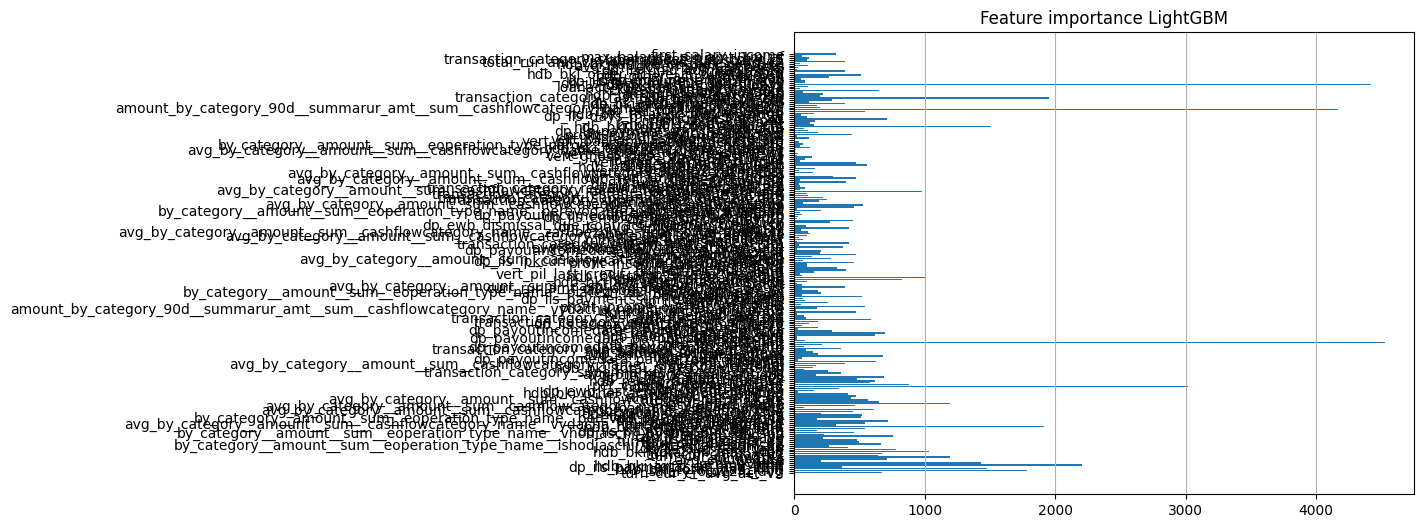

In [88]:
plt.figure(figsize=(8,6))
plt.barh(lgbm_reg.feature_names_in_,lgbm_reg.feature_importances_)
plt.grid(axis='x')
plt.title('Feature importance LightGBM')

In [ ]:
# WMAE = weighted_mean_absolute_error(train_df['target'], train_df['predict'], train_df['w'])
# print(f"WMAE = {WMAE:.2f}")

# Save result

In [90]:
test_data[object_col] = test_data[object_col].astype('category')
preds = lgbm_reg.predict(test_data.drop(columns=['id', 'dt']))
result = pd.DataFrame(data={'ID':test_data['id'], 'target':np.expm1(preds)})
result.to_csv("submission.csv", index=False)